In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader

import sys

sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

# from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL
from ElectricPropertiesNN_PL import ElectricPropertiesNN_PL


## Load trained Models

In [3]:
models = pd.DataFrame()

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 100
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
original_dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
original_stats = pd.DataFrame.from_dict(original_dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_19-discrimination_dataset-capacitance"
raw_dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
new_stats = pd.DataFrame.from_dict(dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
dset.worms_properties_stats = original_dset.worms_properties_stats
dset.worms_properties = (
    dset.worms_properties[:] * new_stats.loc["std"].to_numpy()
    + new_stats.loc["mean"].to_numpy()
    - original_stats.loc["mean"].to_numpy()
) / original_stats.loc["std"].to_numpy()
dloader = DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=12)

#### Load full end-to-end models

In [5]:
for folder in list(np.sort(glob.glob("../figures/stats-panel/full-model*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNN_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "full", "model": [model]}),
        ]
    ).reset_index(drop=True)

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# load the retrained scale model
# checkpoint_path = f"../electric-properties-only/retrain_scale/lightning_logs/version_4/checkpoints/epoch=599-step=21000.ckpt"
checkpoint_path = f"../electric-properties-only/retrain_scale/lightning_logs/version_6/checkpoints/epoch=999-step=35000.ckpt"
retrained_scale_model = ElectricPropertiesNN_PL.load_from_checkpoint(checkpoint_path)
retrained_scale_model.eval()
retrained_scale_model.freeze()
retrained_scale_model.cpu()

ElectricPropertiesNN_PL(
  (model): ElectricPropertiesNN(
    (sequence): Sequential(
      (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=2, out_features=10, bias=True)
      (2): ReLU()
      (3): Linear(in_features=10, out_features=20, bias=True)
      (4): ReLU()
      (5): Linear(in_features=20, out_features=10, bias=True)
      (6): ReLU()
      (7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [7]:
for i, folder in enumerate(list(np.sort(glob.glob("../figures/stats-panel/feedback-with-values*")))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    model.model.spatial_model = models.loc[i, "model"].model
    # model.model.spatial_model.linear.fc3.linear.weight = torch.nn.Parameter(models.loc[i, "model"].model.linear.fc3.linear.weight[:4].clone())
    model.model.feedback_model = retrained_scale_model.model
    
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_vals", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

for i, folder in enumerate(list(np.sort(glob.glob("../figures/stats-panel/feedback-with-estimates*")))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    model.model.spatial_model = models.loc[i, "model"].model
    # model.model.spatial_model.linear.fc3.linear.weight = torch.nn.Parameter(models.loc[i, "model"].model.linear.fc3.linear.weight[:4].clone())
    model.model.feedback_model = retrained_scale_model.model
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_esti", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

In [8]:
models = models[models["lambda_RC"] > 0].reset_index(drop=True)
# models = models[models["model_type"]=="full"].reset_index(drop=True)

In [9]:
models

,rand_seed,lambda_RC,model_type,model
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
5,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
6,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
7,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
8,113,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
9,113,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...


## Inspect discrimination data

In [10]:
eis = next(iter(dloader))[0]
props = next(iter(dloader))[1].to(torch.float32)
discrimination_data = raw_dataset["worms"]["dataframe"].copy()
max_mod = eis[:, :, 5, 6]
print(eis.shape, max_mod.shape)

torch.Size([100, 2, 20, 30]) torch.Size([100, 2])


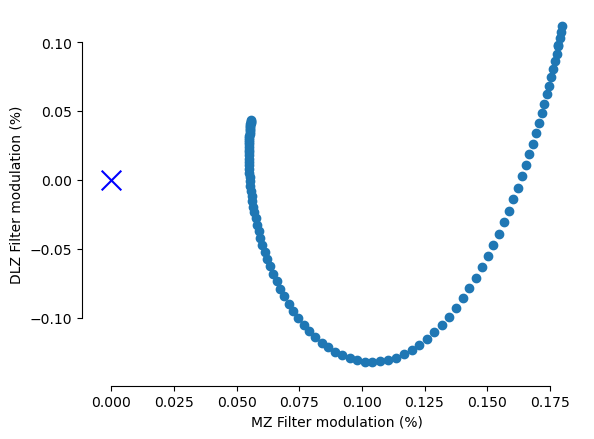

In [11]:
plt.scatter(*eis[:, :, 5, 6].T)
plt.scatter([0], [0], c="b", marker="x", s=200)
plt.xlabel("MZ Filter modulation (%)")
plt.ylabel("DLZ Filter modulation (%)")
sns.despine(offset=5, trim=True)
plt.savefig("discrimination-feat-space.svg")
plt.show()

## Prepare discrimination training data

In [11]:
n_repeats = 20
noise_amount = 0.05

train_eis = torch.tile(eis, (n_repeats * len(discrimination_data), 1, 1, 1))
train_eis = train_eis + torch.randn_like(train_eis) * noise_amount
train_capacitances_ids = np.tile(discrimination_data["capacitances"], (n_repeats * len(discrimination_data),))
train_props = torch.tile(props, (n_repeats * len(discrimination_data), 1))
valid_eis = torch.tile(eis, (n_repeats, 1, 1, 1))
valid_capacitances_ids = np.tile(discrimination_data["capacitances"], (n_repeats,))
valid_props = torch.tile(props, (n_repeats, 1))

#### run models on the EIs

In [ ]:
models["prediction_train"] = models.apply(
    lambda x: (
        x["model"].model(train_eis, train_props[:, 1], train_props[:, 3]).detach().cpu().numpy()
        if x["model_type"] == "feedback_vals"
        else x["model"].model(train_eis).detach().cpu().numpy()
    ),
    axis=1,
)
models["prediction_valid"] = models.apply(
    lambda x: (
        x["model"].model(valid_eis, valid_props[:, 1], valid_props[:, 3]).detach().cpu().numpy()
        if x["model_type"] == "feedback_vals"
        else x["model"].model(valid_eis).detach().cpu().numpy()
    ),
    axis=1,
)

## Compute models predictions

### single model example

In [14]:
model = models.iloc[0]["model"]
pref_c_id = 31
n_repeats = 100
noise_amount = 0.1

mask_sp = discrimination_data["capacitances"] == pref_c_id
mask_sm = ~mask_sp
eis_sp = eis[mask_sp]
eis_sm = eis[mask_sm]
train_eis_sp = torch.tile(eis_sp, (len(eis_sm), 1, 1, 1))
train_eis_sp = torch.tile(train_eis_sp, (n_repeats, 1, 1, 1))
train_eis_sm = torch.tile(eis_sm, (n_repeats, 1, 1, 1))
train_eis_sp = train_eis_sp + torch.randn_like(train_eis_sp) * noise_amount
train_eis_sm = train_eis_sm + torch.randn_like(train_eis_sm) * noise_amount
train_preds_sp = model.model(train_eis_sp).detach().numpy()
train_preds_sm = model.model(train_eis_sm).detach().numpy()
train_preds_mixed = np.stack([train_preds_sp, train_preds_sm])
train_choices = np.random.rand(2, len(train_preds_sp)).argsort(0)
train_preds_mixed = train_preds_mixed[train_choices, np.arange(len(train_preds_sp))]
train_x = train_preds_mixed.transpose(1,2,0).reshape(len(train_preds_sp), -1)
train_y = train_choices[1].astype(int)
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1)
rfc.fit(train_x, train_y)
train_y_hat = rfc.predict(train_x)
print((train_y_hat == train_y).mean())

valid_eis_sm = torch.tile(eis, (n_repeats, 1, 1, 1))
valid_eis_sp = torch.tile(eis[mask_sp], (len(valid_eis_sm), 1, 1, 1))
valid_eis_sp = valid_eis_sp + torch.randn_like(valid_eis_sp) * noise_amount
valid_eis_sm = valid_eis_sm + torch.randn_like(valid_eis_sm) * noise_amount
valid_preds_sm = model.model(valid_eis_sm).detach().numpy()
valid_preds_sp = model.model(valid_eis_sp).detach().numpy()
valid_x = np.stack([valid_preds_sp, valid_preds_sm]).transpose(1,2,0).reshape(len(valid_preds_sp), -1)
valid_y = np.ones(len(valid_preds_sp), dtype=int)
valid_y_hat = rfc.predict(valid_x)
valid_df = pd.DataFrame({"capacitance_id":np.tile(discrimination_data["capacitances"], (n_repeats,)), "y": valid_y, "y_hat": valid_y_hat})
discrimination_performance = valid_df.groupby("capacitance_id").apply(lambda x: (x["y"] == x["y_hat"]).mean() * 100)

0.923030303030303


In [15]:
np.diff(raw_dataset["worms"]["capacitances"][np.where(discrimination_performance < 75)[0][[0,-1]]]) / 1e-9

array([2.94225838])

2.253876394303584

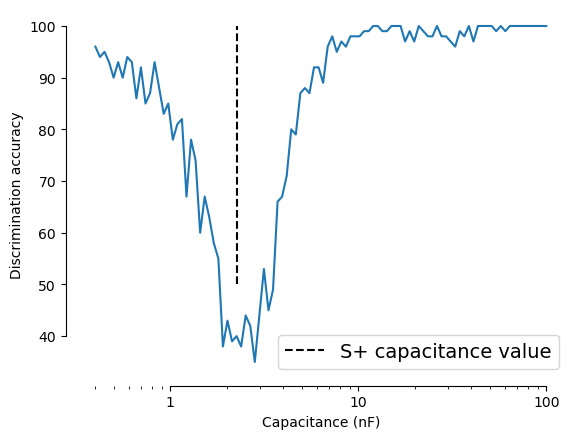

In [22]:
plt.plot(raw_dataset["worms"]["capacitances"], discrimination_performance)
select_C = raw_dataset["worms"]["capacitances"][pref_c_id]
plt.plot([select_C, select_C], [50, 100], "k--", label="S+ capacitance value")
plt.xscale("log")
sns.despine(offset=5, trim=True)
plt.xticks([1e-9, 1e-8, 1e-7], ["1", "10", "100"])
plt.xlabel("Capacitance (nF)")
plt.ylabel("Discrimination accuracy")
plt.legend(fontsize=14)    
plt.show()

### run for all models

In [ ]:
def train_capacitance_discrimination(dfrow):
    
    return dfrow

In [15]:
def train_discrimination(
    dfrow, n_repeats=n_repeats, noise_amount=noise_amount, discrimination_data=discrimination_data, props=props, eis=eis
):
    print(dfrow["model_type"], dfrow["lambda_RC"], end=" | ")
    model = dfrow["model"]
    dfrow["discrimination_performance"] = []
    props = torch.tile(props, (n_repeats, 1))
    for c_id in discrimination_data["capacitances"].unique():
        print(c_id, end=" ")
        labels = np.zeros(len(discrimination_data))
        labels[c_id] = 1
        labels = np.tile(labels, (n_repeats))
        train_eis = torch.tile(eis, (n_repeats, 1, 1, 1))
        train_eis = train_eis + torch.randn_like(train_eis) * noise_amount
        valid_eis = torch.tile(eis, (n_repeats, 1, 1, 1))
        valid_eis = train_eis + torch.randn_like(valid_eis) * noise_amount

        prediction_train = (
            model.model(train_eis, props[:, 1], props[:, 3]).detach().cpu().numpy()
            if dfrow["model_type"] == "feedback_vals"
            else model.model(train_eis).detach().cpu().numpy()
        )
        shuffle_perm = np.random.permutation(len(train_eis))
        train_x = prediction_train[shuffle_perm]
        train_y = labels[shuffle_perm]
        rfc = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1)
        rfc.fit(train_x, train_y)

        c_ids = np.tile(discrimination_data["capacitances"], (n_repeats))
        prediction_valid = (
            model.model(valid_eis, props[:, 1], props[:, 3]).detach().cpu().numpy()
            if dfrow["model_type"] == "feedback_vals"
            else model.model(valid_eis).detach().cpu().numpy()
        )
        valid_preds = rfc.predict(prediction_valid)
        discrimination_performance = pd.DataFrame(
            {
                "capacitance_id": c_ids,
                "valid_preds": valid_preds,
                "labels": labels,
            }
        )
        discrimination_performance = discrimination_performance.groupby("capacitance_id").apply(
            lambda x: (x["valid_preds"] == x["labels"]).mean() * 100
        )
        dfrow["discrimination_performance"].append(discrimination_performance)
    print()
    return dfrow

In [ ]:
models = models.iloc[:1].apply(train_discrimination, axis=1)

In [ ]:
models.to_pickle("discrimination_performance.pkl")

In [ ]:
model_id = 0
dfrow = models.iloc[model_id]
discrimination_performance = dfrow["discrimination_performance"]

plt.figure(figsize=(20, 5))
for i in range(len(discrimination_performance)):
    plt.plot(discrimination_performance[i], label=f"Capacitance {i}", c=plt.cm.viridis(i/len(discrimination_performance)), alpha=0.5)
plt.ylim(-1, 101)
sns.despine(offset=5, trim=True)
plt.show()